In [1]:
from PIL import Image
import os, random, re
import numpy as np
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
from matplotlib import transforms
import pickle
import json
import torch
from typing import List, Tuple
from pprint import pprint

COLORS = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4',
         '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff',
         '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1',
         '#000075', '#808080', '#000000']

## Funcstions
  - functons to find positive CoM chains
  - funcstions to visualize CoM chains for each image sample stored in .jsonl file

In [2]:
class Node:
    def __init__(self, data, key):
        self.key = key
        self.data = data

def build_tree(dict_tree):
    dtree = {}
    max_depth = 0
    for k,v in dict_tree.items():
        k = k.replace('*', '~')
        dtree[k] = v
        max_depth  = (k.split('--')[1].split(',')[0])

    tree = {}
    for key in sorted(dtree.keys()):
        fid, curid = key.split('--')
        flevel, ford = fid.split(',')
        clevel, cord = curid.split(',')
        if ford == '~':
            for i in range(1000): # maximum
                fid = f'{flevel},{i}'
                if fid not in tree:
                    if fid.split(',')[0] == '-1' and i==0: # one root
                        tree[fid] = [Node(dtree[key], key)]
                        if clevel != max_depth:
                            tree[curid] = [] # add current node !
                    break
                tree[fid].append(Node(dtree[key], key))
                if clevel != max_depth:
                    tree[curid] = []
        else:
            tree[fid] = tree.get(fid, []) + [Node(dtree[key], key)]
            if clevel != max_depth:
                tree[curid] = []
    return tree


def find_paths(tree):
    paths = []
    level = 0
    path = []
    def dfs(node):
        nonlocal tree, path
        fid, curid = node.key.split('--')
        path.append(node)
        if 'found' in node.data and node.data['found']:
            # paths.append([n.data['found'] for n in path])
            paths.append([n.data for n in path])
        if curid in tree:
            for child in tree[curid]:
                dfs(child)
        path.pop()
    # for root in tree[0]:
    for root in tree.get('-1,0', []):
        dfs(root)
    return paths

In [3]:
# add captions
def draw_text(ax, x, y, text, color, transform):
    text = ax.text(x,y,text,color=color, transform=transform)
    text.draw(ax.figure.canvas.get_renderer())
    ex = text.get_window_extent()
    t = transforms.offset_copy(text._transform, x=ex.width, units='dots')
    return t, ex

In [29]:
def visualize_com(ann, save_name=None, print_label=True):
    """ The ann contains image_path, questions, answers and corresponding grounding information.
    """
    

    img = ann['image_path']
    QAs = ann['metadata']
    img_ann = ann.get('image_ann', None)
    print(f"image_path: {img}")
    
    for qa in QAs:
        if not qa.get('final_com', None):
            continue

        # Each row for a chain of com
        tree = build_tree(qa['final_com'])
        chains = find_paths(tree)
        # import ipdb
        # ipdb.set_trace()
        if len(chains)==0:
            continue

        print(f"Q: {qa['question']}")
        print(f"A: {qa['answer']}")

        pil_img = Image.open(img)
        max_len = max([len(c) for c in chains])
        fig, axes = plt.subplots(len(chains), max(2, max_len), figsize=(18,4))
        axes = [axes] if len(chains)==1 else axes
        boxid, phr2boxid = 0, {}
        for i, chain in enumerate(chains):
            print(f"------ chain {i} -------")
            for ii, com in enumerate(chain):
                func, param, variables, desc = com['func'], com['param'], com['variables'], com['desc']
                if variables:
                    for iii, (vk, vv) in enumerate(variables.items()):
                        boxid += iii
                        if 'bbx' in vk:
                            # draw box
                            if isinstance(vv, list) and (isinstance(vv[0], int) or isinstance(vv[0], float)):
                                vv= [vv]
                            elif isinstance(vv, list) and isinstance(vv[0], list):
                                vv = vv
                            for box in vv:
                                axes[i][ii].add_patch(Rectangle(
                                    (box[0], box[1]),
                                    box[2] - box[0],
                                    box[3] - box[1],
                                    fill = False,
                                    edgecolor= COLORS[boxid%len(COLORS)],
                                    # linewidth=10
                                ))
                                axes[i][ii].text(box[0], box[1],
                                    "{}".format(param),
                                    bbox={'facecolor':'white', 'alpha':0.7, 'pad':2},
                                    style='italic',
                                    color=COLORS[boxid%len(COLORS)])
                                phr2boxid[param] = boxid
                # axes[i, ii].set_title(desc)
                axes[i][ii].text(-8, pil_img.size[1], desc, ha='left', rotation=90, wrap=True)
                print(desc)
        
                x, y = 0, pil_img.size[1]+30
                qas = []
                if print_label:
                    pre_words, phrase, post_words = desc, "", ""
                    for phr in phr2boxid:
                        pos = desc.find(phr)
                        if pos != -1:
                            phrase, ph_s, ph_e = desc[pos: pos+len(phr)], pos, pos+len(phr)
                            pre_words, post_words = desc[:ph_s], desc[ph_e:]
                        # t = plt.gca().transData
                        t = axes[i][ii].transData
                        # plot
                        t, ex = draw_text(axes[i][ii], x, y, pre_words+' ', "#000000", t, plt.gca().transData)
                        if phrase:
                            t, ex = draw_text(axes[i][ii], x, y, phrase+ '', COLORS[phr2boxid[phrase]%len(COLORS)], t, plt.gca().transData)
                            t, ex = draw_text(axes[i][ii], x, y, post_words, "#000000", t, plt.gca().transData)
                        y += ex.height+15

                axes[i][ii].axes.xaxis.set_visible(False)
                axes[i][ii].axes.yaxis.set_visible(False)
                axes[i][ii].tick_params(labelbottom='off', labelleft='off')
                axes[i][ii].imshow(pil_img)
    plt.show()
    if save_name:
        # fig = plt.gcf()
        # fig.savefig(save_name, dpi=400)
        fig.savefig(save_name)

# Visualize
  - specify jsonl file (e.g., com_math.jsonl)

image_path: images/TextVQA/train_val_train_images_b9dc400eb20bad64.jpg
Q: what does the small white text spell?
A: copenhagen
------ chain 0 -------
Utilizing GROUNDING(the small white text) to locate the small white text in the image and return the corresponding box as `bbx_1`.
Utilizing CROP_AND_ZOOMIN(`bbx_1`) to crop the current image by the region `bbx_1` and zoom in the cropped image by two times, resulting `img_1`.
Utilizing OCR(`img_1`) to recognize the small white text in image `img_1` and return the recognized text as `txt_1`.).


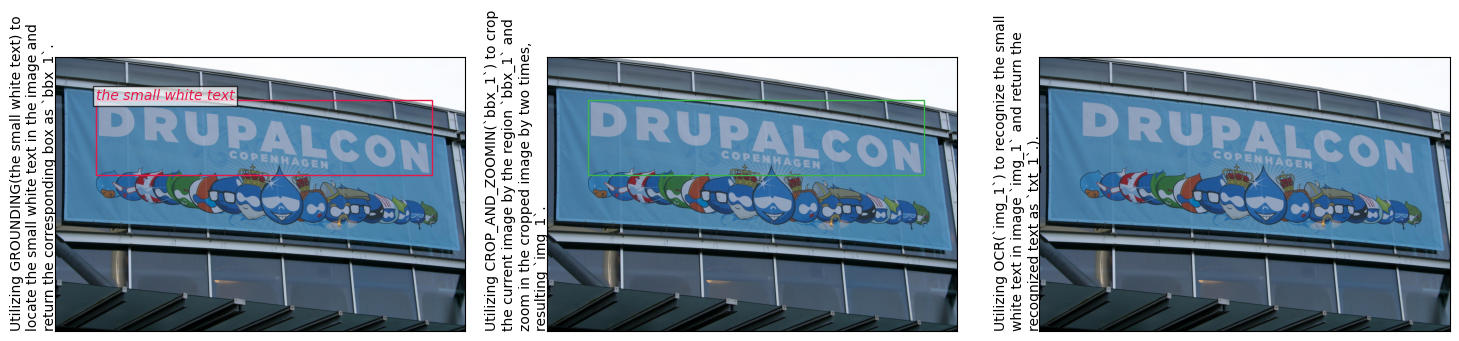

In [30]:
# view com_test
data = []
with open('com_test.jsonl') as f:
    for line in f:
        data.append(json.loads(line))

# visualize
visualize_com(data[1], print_label=False, save_name='eg_comtest.png')

image_path: images/MathVista/images_284.jpg
Q: What is the accuracy of the algorithm with lowest accuracy?
A: 1
------ chain 0 -------
Firstly, use GROUNDING(lowest) to find the least accurate algorithm in the diagram, which is globe, located at `bbx_2`.
Secondly, use LINE([121, 200, 126, 600], 1, 4)->img_1 to find the value corresponding to the least accurate algorithm in the diagram, which is 1, obtaining the new image `img_1`.
So the final answer is 1.


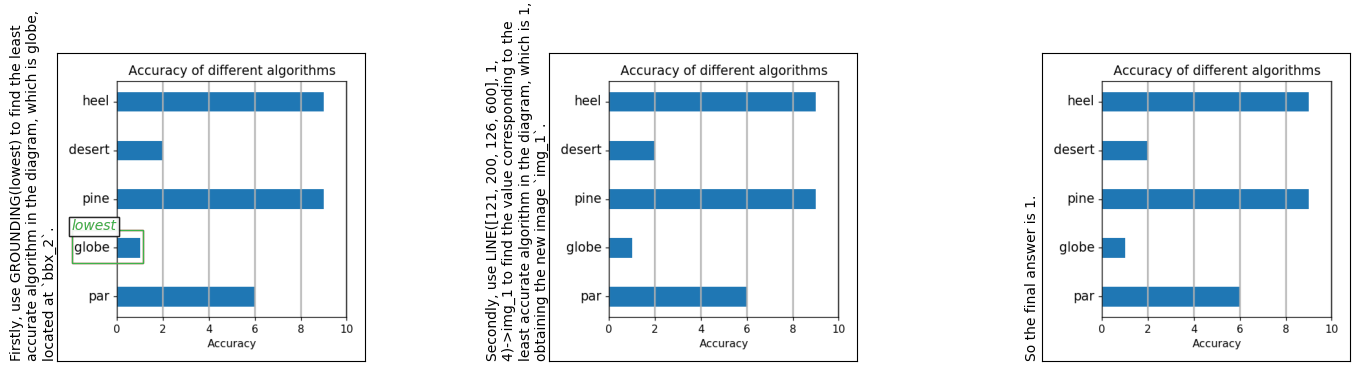

image_path: images/MathVista/images_549.jpg
Q: As shown in the figure, PA and PB are tangent to ⊙O to A and B respectively. Point C and point D are the moving points on line segments PA and PB, and CD always remains tangent to circle O. If PA = 8.0, then perimeter of △PCD is ()
Choices:
(A) 8
(B) 12
(C) 16
(D) 不能确定
A: 16
------ chain 0 -------
Draw a Line with LINE([42, 8, 61, 57],4,2)->img_1, obtaining the new image `img_1` with the line drawn.
Then, draw a Line with LINE([38, 48, 93, 56],4,2)->img_2, obtaining the new image `img_2` with the line drawn.
After that, draw a Line with LINE([45, 56, 68, 100],1,3)->img_3, obtaining the new image `img_3` with the line drawn.
Since PA and PB are tangent to circle O at points A and B respectively. Points C and D are moving points on segments PA and PB, and CD always remains tangent to circle O. Therefore, triangle OAC is congruent to triangle OEC, and triangle OBE is congruent to triangle ODE, thus AC = EC and BD = ED.
Therefore, S△PCD = PC +

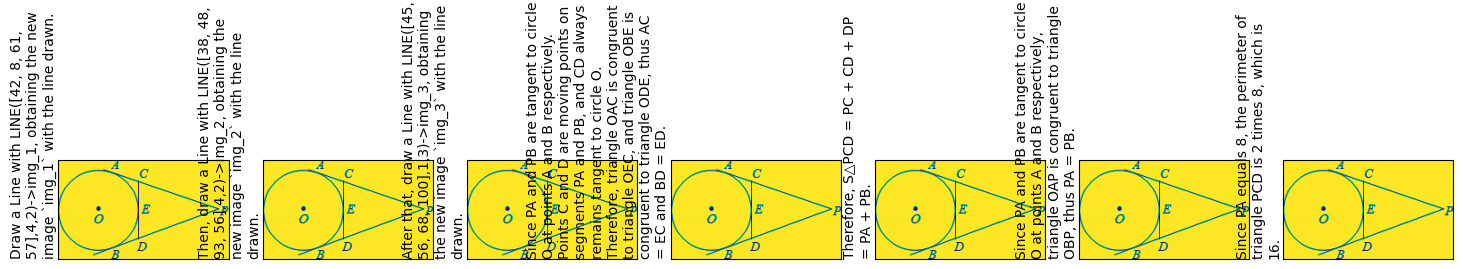

In [31]:
# view com_math
data = []
with open('com_math.jsonl') as f:
    for line in f:
        data.append(json.loads(line))

# visualize
visualize_com(data[3], print_label=False, save_name='eg_commath3.png')
visualize_com(data[20], print_label=False, save_name='eg_commath20.png')